In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import behav_cleaning as bc
import numpy as np
from pathlib import Path
import sys
sys.path.append('..')
import paths

from importlib import reload
reload(paths)

/Users/au281249/Documents/code/Respiratory_DDM-1


<module 'paths' from '../paths.py'>

In [13]:
# Import csv with logfiles from all subjects
data_file_path = paths.data_master
data = pd.read_csv(data_file_path)
print(len(data))
data=data.loc[data.trialType=='experiment'] # only keep test trials (exclude introduction and staircase trials)
print(len(data))

# create plotter object
plotter = bc.plot()


33721
26240


In [14]:
# print subject ID's
print(data.subject.unique())

[1003  179 1002 1001  211  190  132  210 1006  525 1007 1004 1005 1011
 1008  123 1010  219 1009 1013  171 1012  184   19 1014 1015 1016 1017
   90   94  111   66  224   72   98   80  220  118   27   76  101]


In [15]:
# define max values for bad trials or subjects
fastRT = 0.1    # in sec. - faster than this is a fast trial
maxNumberOfMissedTrials = 30    # max number per subject per task
maxAbsCriterion = 0.6   # higher values in RDM are taken to indicate poor task compliance

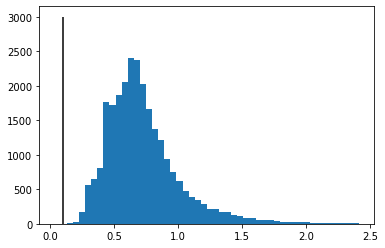

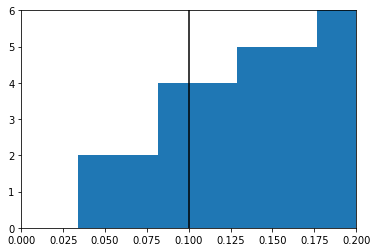

n fast trials:  3


In [16]:
# set fast trials as fast trials
data = bc.setBadTrials(data, 'rt', fastRT, '<', 'fastTrial')

#plot all rt's 
plt.hist( data.rt, bins=50)
plt.vlines(0.1,0,3000, color='k')
plt.show()
plt.hist( data.rt, bins=50)
plt.vlines(0.1,0,3000, color='k')
plt.xlim(0,0.2)
plt.ylim(0,sum(data.fastTrial)*2)
plt.show()
print('n fast trials: ',sum(data.fastTrial))

bad subjects RDM  []
bad subjects Emo []


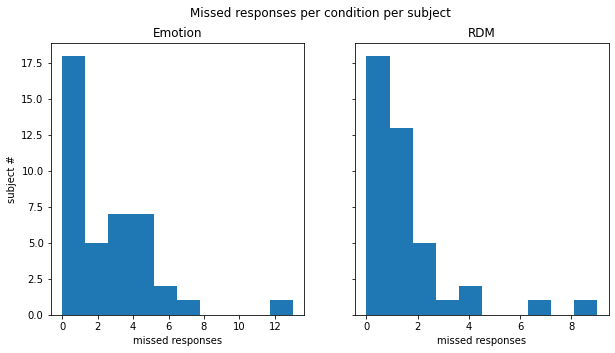

In [11]:
# # plot number of missed trials per condition per subject
meta = bc.getSubjectLvlData(data, fastRT=fastRT)
plotter.missedResponses(meta)

# get subjects with hig number of missed trials in each task
badSubjectsRDM = bc.getBadSubjects(meta, 'missedRDM', maxNumberOfMissedTrials, '>')
badSubjectsEmo = bc.getBadSubjects(meta, 'missedEmo', maxNumberOfMissedTrials, '>')
print('bad subjects RDM ', badSubjectsRDM)
print('bad subjects Emo', badSubjectsEmo)

#set column with 'True'  if subjects have high number of missed trials
data = bc.setExclusion(data, badSubjectsRDM, 'missedTrialsRDM')
data= bc.setExclusion(data, badSubjectsEmo, 'missedTrialsEmo')

bad subjects  [90.0, 94.0, 72.0, 80.0]


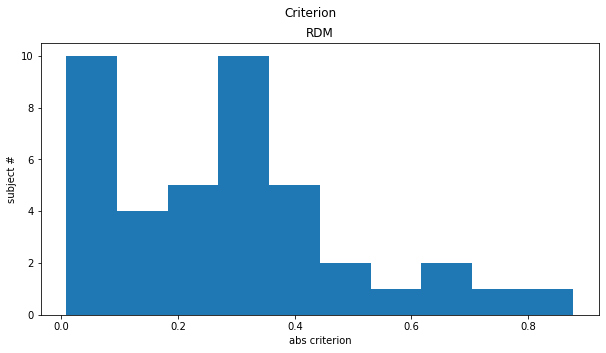

In [12]:
# plot criterion in RDM
plotter.criterion(meta)

# get subjects with abs criterion > maxAbsCriterion
badSubjects = bc.getBadSubjects(meta, 'absC', maxAbsCriterion, '>')
print('bad subjects ', badSubjects)

#set column with 'True'  if subjects abs criterion > 0.6
data = bc.setExclusion(data, badSubjects, 'bad_absC')

Exclude bad trials and subjects,
Remove redundant cols,
Rename stuff,
Save df for each task with only experiment trials

In [13]:
# add trial number
blockTrials = []
for subject in data.subject.unique():
    for task in data.stimuli.unique():
        for block in data.block.unique():
            l = len(data.loc[(data.subject==subject) & (data.block==block) & (data.stimuli==task)])
            blockTrials.append(np.arange(0,l))
            # for i in range(l):
            #     data.loc[(data.subject==subject) & (data.block==block) & (data.stimuli==task)]
trialNumberList = np.concatenate(blockTrials)
data.trialNumber = trialNumberList


# set respons to 1 or 0
data.loc[data.response == 'up', 'response'] = 1
data.loc[data.response == 'down', 'response'] = 0


## sclect RDM trials  
rdm = data.loc[data.stimuli == 'cRDM'] # only random dot motion trials are relevant
rdmOld = rdm.copy()
# reject trials and subject based on behavioural measures
rdm = rdm.dropna(subset=['response']) # remove trials wo. response
rdm = rdm.loc[rdm.bad_absC == False] # removed biased subjects
rdm = rdm.loc[rdm.fastTrial == False] # removed unrealisticly fast trials

rdm = rdm.rename(columns={'rand':'dir'})
rdm.loc[rdm.dir == 'up', 'dir'] = 1
rdm.loc[rdm.dir == 'down', 'dir'] = 0
# drop redundant columns
rdm=rdm.drop([
            'stimuli', 'trialType', 'bad_absC', 'fastTrial',
              'Unnamed: 0', 'Unnamed: 0.1', 'missedTrialsRDM', 'missedTrialsEmo',
              'estIntens', 'estThres', 'estSlope', 'onset', 'responsI','stimTime',
              'trialStart','headRest',
              ], axis=1) 


## select FAD trials
fad = data.loc[data.stimuli == 'emotion'] # only face affect diskrimination trials are relevant
fadOld = fad.copy()
# reject trials and subject based on behavioural measures
fad = fad.dropna(subset=['response']) # remove trials wo. response
fad = fad.loc[fad.fastTrial == False] # removed unrealisticly fast trials


# create emotion lvl column with 4 catagroical levels for all subs instead of their personal levels
fad['emotion'] = None
for sub in fad.subject.unique():
    lvls = fad.loc[fad.subject == sub]['stimLvl'].unique() # get list of stimlvls for per subject
    lvls.sort()
    fad.loc[(fad.subject == sub) & (fad.stimLvl == lvls[0]), 'emotion'] = 0
    fad.loc[(fad.subject == sub) & (fad.stimLvl == lvls[1]), 'emotion'] = 1
    fad.loc[(fad.subject == sub) & (fad.stimLvl == lvls[2]), 'emotion'] = 2
    fad.loc[(fad.subject == sub) & (fad.stimLvl == lvls[3]), 'emotion'] = 3
    
# drop redundant columns
fad=fad.drop([
             'stimuli', 'trialType', 'bad_absC', 'fastTrial',
              'Unnamed: 0', 'Unnamed: 0.1', 'missedTrialsRDM', 'missedTrialsEmo',
              'estIntens', 'estThres', 'estSlope', 'onset', 'responsI','stimTime',
              'trialStart','headRest', 'rand', 'hit'
              ], axis=1) 

In [9]:
# save analysis ready csvs
rdm.to_csv(paths.rdm_data)
fad.to_csv(paths.fad_data)

# Performance information
FAD

In [14]:
p_happy = np.full((len(fad.subject.unique()), 4,), np.nan)
for sub in range(len(fad.subject.unique())):
    s = fad.subject.unique()[sub]
    lvl0, lvl1, lvl2, lvl3 = fad.loc[(fad.subject==s) & (fad.emotion == 0)], fad.loc[(fad.subject==s) & (fad.emotion == 1)], fad.loc[(fad.subject==s) & (fad.emotion == 2)], fad.loc[(fad.subject==s) & (fad.emotion == 3)]
    p_happy[sub,:] = sum(lvl0.happy)/len(lvl0), sum(lvl1.happy)/len(lvl1), sum(lvl2.happy)/len(lvl2), sum(lvl3.happy)/len(lvl3)

np.round(np.mean(p_happy,axis=0),2), np.round(np.std(p_happy,axis=0),2)

(array([0.32, 0.42, 0.53, 0.6 ]), array([0.17, 0.17, 0.18, 0.16]))

RDM

In [15]:
hr = np.full((len(rdm.subject.unique()), 1,), np.nan)
for sub in range(len(rdm.subject.unique())):
    s = rdm.subject.unique()[sub]
    sub_dat= rdm.loc[(rdm.subject==s)]
    hr[sub] = sum(sub_dat.hit)/len(sub_dat)

np.round(np.mean(hr,axis=0),2), np.round(np.std(hr,axis=0),2)

(array([0.74]), array([0.1]))

# Stimuli information
RDM:

mean 0.21, SD 0.14, range 0.06-0.49


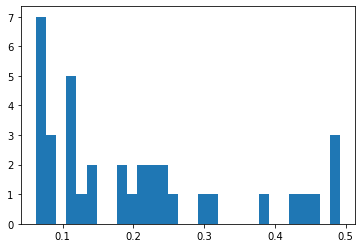

In [16]:
stimLvls = []
for sub in rdm.subject.unique():
    stimLvls.append(rdm.loc[rdm.subject==sub].stimLvl.unique()[0])
    
plt.hist(stimLvls, bins=30)
mean = round(np.mean(stimLvls),2)
sd = round(np.std(stimLvls),2)
min = round(np.min(stimLvls),2)
max = round(np.max(stimLvls),2)


print(f'mean {mean}, SD {sd}, range {min}-{max}')

FAD

In [18]:
len(fad.subject.unique())

41

# Demographics and rejection stats

In [19]:
demo = pd.DataFrame()

for sub in np.sort(data.subject.unique()):
    sDat = data.loc[data['subject'] == sub]
    age = sDat.age.set_axis(range(len(sDat)))
    g = sDat.gender.set_axis(range(len(sDat)))


    demo = demo.append({'sub':sub,
                        'age':age[0],
                        'gender':g[0]}, ignore_index=True)

demo.to_csv(paths.demographics)   

In [20]:
print(f'mean age: {round(np.mean(demo.age),1)}')
print(f'age std: {round(np.std(demo.age),1)}')
female = sum(demo.gender=='female')
print(f'female: {female}')

mean age: 26.0
age std: 5.9
female: 27


In [47]:
# number of trials left after removing missed responses and fast trials
for data, task in zip([rdm, fad], ['RDM', 'FAD']):
    nTrials = []
    for sub in data.subject.unique():
        nTrials.append(len(data.loc[data.subject==sub]))
    print(f'number of {task} trials:', round(np.mean(nTrials),1), 'SD',round(np.std(nTrials),1), 'range', np.min(nTrials), np.max(nTrials))
    print(f'mean % of total {task} trials removed per sub:', round(((320-np.mean(nTrials))/320)*100,1), 'SD', round(np.std(((320-np.array(nTrials))/320)*100),1), 'range', 320-np.max(nTrials), 320-np.min(nTrials))
    print('')

number of RDM trials: 318.7 SD 2.0 range 311 320
mean % of total RDM trials removed per sub: 0.4 SD 0.6 range 0 9

number of FAD trials: 317.6 SD 2.7 range 307 320
mean % of total FAD trials removed per sub: 0.7 SD 0.8 range 0 13



In [53]:
# number of trials left after removing man bad
for data, task in zip([rdm, fad], ['RDM', 'FAD']):
    for locking, name in zip(['manBadOnset', 'manBadRespons'], ['onset','respons']):
        nDiff = []
        nTrials = []
        for sub in data.subject.unique():
            nTrialsBefore = len(data.loc[(data.subject==sub)])
            nTrialsNow = len(data.loc[(data.subject==sub) & (data[locking] != True)])
            nTrials.append(nTrialsNow)
            nDiff.append(nTrialsBefore-nTrialsNow)
        print(f'number of {task} trials for {name} :', round(np.mean(nTrials),1), 'SD',round(np.std(nTrials),1), 'range', np.min(nTrials), np.max(nTrials),1)
        print('diff', round(np.mean(nDiff)), np.min(nDiff), np.max(nDiff))
        print(f' % removed {round((np.mean(nDiff)/320)*100,1)}, SD', round(np.std(((320-np.array(nDiff))/320)*100),1))
        print('')

number of RDM trials for onset : 313.2 SD 8.6 range 284 320 1
diff 6 0 36
 % removed 1.7, SD 2.6

number of RDM trials for respons : 313.1 SD 8.5 range 287 320 1
diff 6 0 33
 % removed 1.7, SD 2.6

number of FAD trials for onset : 310.9 SD 10.4 range 270 320 1
diff 7 0 46
 % removed 2.1, SD 3.0

number of FAD trials for respons : 311.0 SD 10.3 range 270 320 1
diff 7 0 46
 % removed 2.1, SD 3.0



In [54]:
# number of trials left after removig peak trough
# creat dfs wo. manual bad trials
rdmOns = rdm.loc[(rdm.manBadOnset != True)]
rdmRes = rdm.loc[(rdm.manBadRespons != True)]
fadOns = fad.loc[(fad.manBadOnset != True)]
fadRes = fad.loc[(fad.manBadRespons != True)]

# see effect of peak and triugh trials removal
for data, task, locking, name in zip( [rdmOns, rdmOns, fadOns, fadRes], ['RDM', 'RDM', 'FAD', 'FAD'], ['onset_phase', 'respons_phase', 'onset_phase', 'respons_phase'], ['onset', 'respons', 'onset', 'respons']):
    nDiff = []
    nTrials = []
    for sub in data.subject.unique():
        nTrialsBefore = len(data.loc[(data.subject==sub)])
        nTrialsNow = len(data.loc[(data.subject==sub) & (data[locking] != 'peak') & (data[locking] != 'trough')])
        nTrials.append(nTrialsNow)
        nDiff.append(nTrialsBefore-nTrialsNow)
    print(f'number of {task} trials for {name} :', round(np.mean(nTrials),1), 'SD',round(np.std(nTrials),1), 'range', np.min(nTrials), np.max(nTrials),1)
    print('diff', round(np.mean(nDiff)), np.min(nDiff), np.max(nDiff))
    print(f' % removed {round((np.mean(nDiff)/320)*100,1)},   SD', round(np.std(((320-np.array(nDiff))/320)*100),1))
    print(f'total mean % removed {round(((320-np.mean(nTrials))/320)*100,1)},  SD', round(np.std(((320-np.array(nTrials))/320)*100),1))
    print('')

number of RDM trials for onset : 295.8 SD 8.4 range 266 307 1
diff 17 8 26
 % removed 5.4,   SD 1.3
total mean % removed 7.6,  SD 2.6

number of RDM trials for respons : 296.2 SD 9.5 range 267 310 1
diff 17 9 28
 % removed 5.3,   SD 1.7
total mean % removed 7.4,  SD 3.0

number of FAD trials for onset : 294.9 SD 10.6 range 262 312 1
diff 16 3 24
 % removed 5.0,   SD 1.5
total mean % removed 7.9,  SD 3.3

number of FAD trials for respons : 294.2 SD 11.1 range 250 312 1
diff 17 8 26
 % removed 5.2,   SD 1.5
total mean % removed 8.0,  SD 3.5



In [50]:
rdmOnsClean = rdmOns.loc[(rdmOns.onset_phase != 'peak') & (rdmOns.onset_phase != 'trough')]
rdmResClean = rdmRes.loc[(rdmRes.respons_phase != 'peak') & (rdmRes.respons_phase != 'trough')]
fadOnsClean = fadOns.loc[(fadOns.onset_phase != 'peak') & (fadOns.onset_phase != 'trough')]
fadResClean = fadRes.loc[(fadRes.respons_phase != 'peak') & (fadRes.respons_phase != 'trough')]

In [51]:
# remove redundant phase cols
rdmOnsClean = rdmOnsClean.drop(['respons_phase'], axis=1)
rdmResClean = rdmResClean.drop(['onset_phase'], axis=1)
fadOnsClean = fadOnsClean.drop(['respons_phase'], axis=1)
fadResClean = fadResClean.drop(['onset_phase'], axis=1)
# # save dfs
rdmOnsClean.to_csv(paths.rdm_onset_data)
rdmResClean.to_csv(paths.rdm_respons_data)
fadOnsClean.to_csv(paths.fad_onset_data)
fadResClean.to_csv(paths.fad_respons_data)